# Notebook to extract place cell information from the dataset

Import the necessary libraries (including the `pynwb` package)

In [31]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pynwb

In [32]:
import h5py

print(pynwb.__version__)
print(h5py.__version__)
print(np.__version__)

2.3.2
3.7.0
1.23.5


### File reading and information

In [2]:
# Set filepath name to read it with NWB
filepath = Path("data\TestPlitt", "sub-R2_ses-20190219T210000_behavior+ophys_small.nwb")

read_io = pynwb.NWBHDF5IO(filepath, "r")
read_nwbfile = read_io.read()


In [3]:
# Print out file information. This would be from one session
print("Subject info:")
for key, value in read_nwbfile.subject.fields.items():
    print(f"    {key:13}: {value}")

print("\nSession info:")    
print(f"    date/time  : {read_nwbfile.session_start_time}")
print(f"    description: {read_nwbfile.session_description}")

Subject info:
    genotype     : CaMKII-cre hemizygous
    sex          : MALE
    species      : Mus musculus
    subject_id   : R2
    weight       : 23.0 g
    date_of_birth: 2018-11-06 21:00:00-08:00

Session info:
    date/time  : 2019-02-19 21:00:00-08:00
    description: TwoTower_foraging_002_003


### Store some key information

In [4]:
# Neuronal traces from ROIs
ROI_traces = read_nwbfile.processing["ophys"]["Fluorescence"]["RoiResponseSeries"].data
nFrames, nNeurons = ROI_traces.shape
print("{} frames x {} neurons".format(*ROI_traces.shape))

# Deconvolved activity traces
deconvTraces = read_nwbfile.processing["ophys"]["Fluorescence"]["Deconvolved"].data


31932 frames x 2050 neurons


In [30]:
# information of start time for every trial
tstartData = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"]["tstart"].data
tstartData1 = np.array(tstartData)
print(type(tstartData1))
nTrials = int(sum(tstartData))
print("Number of trials for this session is: ", nTrials)

# Matrix that stores where the starting points for each trial is
# Useful to divide trials
startIndices = np.where(tstartData)[0]

<class 'numpy.ndarray'>
Number of trials for this session is:  120


In [6]:
# morph value for each trial (total morph taken as base morph + jitter)
baseMorph = read_nwbfile.stimulus["morph"].data[()]
wallJitter = read_nwbfile.stimulus["wallJitter"].data[()]
totalMorph = baseMorph + wallJitter

# Position of the rat over the session
position = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"]["pos"].data[()]

<div class="alert alert-block alert-info"> Important to note we will be using the <b>baseMorph</b> here. It will be used to classify the trials per morph (and get a place cell classification per session per morph value) </div>

#### Define function to positionally bin the data
## START OF UNUSED CODE

In [8]:
# def positionalBin(data, pos):
#     bins = np.arange(0, 4.51, 0.1)
#     avgResp = np.zeros(len(bins))
#     counterArr = np.zeros(len(bins))

#     for i in range(len(bins)-1):
#         counter = 0 # to keep track of how many data points, to average after accumulation
#         for j in range(len(pos)):
#             if (bins[i] <= pos[j] < bins[i+1]): # if the position falls within the interval
#                 avgResp[i] = avgResp[i] + data[j] # keep accumulating the fluoresence data points in this interval
#                 counter = counter + 1 # keeps track of how many data points are added to average in the end
#         if counter != 0: # to avoid dividing by zero if there aren't any datapoints in a bin
#             counterArr[i] = counter    # store the counter per positional bin 
#             avgResp[i] = avgResp[i]/counter # gets average of the sum after all values in phi have been looped over
#     return avgResp, counterArr


In [ ]:
# # Number of positional bins
# nBins = 46

# # Creating the dataframe with trials x bins
# df = np.zeros([nTrials, nBins])
# occp = np.zeros([nTrials, nBins])

# # Which cell are we performing the binning on?
# cellTrace = deconvTraces[:,0]

# # Make sure to add data for last trial DONE
# for i in range(nTrials):
#     if i < nTrials - 1:
#         l = int(startIndices[i])
#         r = int(startIndices[i+1])
#         df[i,:], occp[i,:] = positionalBin(cellTrace[l:r], position[l:r])
#     else:
#         l = int(startIndices[i])
#         df[i,:], occp[i,:] = positionalBin(cellTrace[l:], position[l:])
#     # df[i,:] = cellActivity/np.mean(cellActivity)



In [ ]:
# trialOccp = np.sum(occp[:,:], axis = 1)
# partialOccp = occp / trialOccp.reshape(-1,1)

In [ ]:
# plt.plot(partialOccp[119,:])

### TO DO LIST:
- Return positional occupancy rate per trial (DONE, we have total time per trial in a session and partial occupancy of each bin within a trial)
- Vectorize the binning function DONE
- Binning function can handle all the neurons in the session DONE
- SI calculation with new occupancy rate and aggregated neuronal activity per morph value and occupancy (DONE)

In [10]:
# def trialize(data, pos, startIndices):
#     myIndices = np.append(startIndices, len(data))
#     datablocks = [np.array(data[myIndices[i]:myIndices[i+1]]) for i in range(len(myIndices)-1)]
#     posblocks = [np.array(pos[myIndices[i]:myIndices[i+1]]) for i in range(len(myIndices)-1)]
#     np.array(datablocks,dtype=object)
#     np.array(posblocks,dtype=object)
    
#     return datablocks, posblocks

In [8]:
# def positionalBinVec2(datablocks, posblocks): # This positional binning function takes in the output from trialize
#     nTrials = len(datablocks)
#     bins = np.arange(0, 4.51, 0.1)
#     accResp = np.zeros((nTrials,len(bins)))
#     counterMat = np.zeros((nTrials,len(bins)-1))
    
#     for i in range(nTrials):
#         # Array of indices indicating which bin each timepoint belongs to, and count of how many elements per bin
#         binInds = np.digitize(posblocks[i],bins) - 1
#         counterMat[i,:] = np.histogram(posblocks[i],bins)[0]
#         tempAcc = np.zeros_like(len(bins)-1)
        
#         # accumulate all values in bin
#         np.add.at(accResp[i,:], binInds, datablocks[i])
        
    
#     return accResp[:,:-1], counterMat

In [9]:
# # This will need to be looped over to generate SI for all cells (deconvTraces[:,i])
# dblocks, pblocks = trialize(deconvTraces[:,4], position, startIndices)
# df, occp = positionalBinVec2(dblocks, pblocks)

## END OF UNUSED CODE

### Classify per morph value

The mathematical equation to identify a place cell is using a spatial information metric:

`SI = summ(p_j x lambda_j x log2(lambda_j/lambda))`

Where:
- p_j is the fractional occupancy of each bin j (how much time is spent in each bin)
- lambda_j is the average activity rate of a cell in position bin j 
- lambda is the position-averaged activity rate of the cell

We need to do this for each of the 5 seperate base morph values `S = 0, 0.25, 0.5, 0.75, 1` 

In [15]:
# Function that calculates the spatial information for one cell for each of the 5 different baseMorph values
def GetSI(df, occp, baseMorphList):
    
    # Each might have a different amount of trials
    base0 = np.where(baseMorphList == 0   )[0]
    base1 = np.where(baseMorphList == 0.25)[0]
    base2 = np.where(baseMorphList == 0.5 )[0]
    base3 = np.where(baseMorphList == 0.75)[0]
    base4 = np.where(baseMorphList == 1   )[0]
     
    
    # Matrix is defined since we are reducing down to one averaged trial for each baseMorph
    nBins = 45
    aggBase = np.zeros([5, nBins])
    
    # Averaging across all trials with the same baseMorph
    aggBase[0,:] = np.sum(df[base0,:], axis = 0) / np.sum(occp[base0,:], axis = 0)
    aggBase[1,:] = np.sum(df[base1,:], axis = 0) / np.sum(occp[base1,:], axis = 0)
    aggBase[2,:] = np.sum(df[base2,:], axis = 0) / np.sum(occp[base2,:], axis = 0)
    aggBase[3,:] = np.sum(df[base3,:], axis = 0) / np.sum(occp[base3,:], axis = 0)
    aggBase[4,:] = np.sum(df[base4,:], axis = 0) / np.sum(occp[base4,:], axis = 0)
    
    # Calculating the partial occupancy ratio for each spatial bin
    aggOccBase = np.zeros([5,nBins])

    aggOccBase[0,:] = np.sum(occp[base0,:], axis = 0) / np.sum(occp[base0,:])
    aggOccBase[1,:] = np.sum(occp[base1,:], axis = 0) / np.sum(occp[base1,:])
    aggOccBase[2,:] = np.sum(occp[base2,:], axis = 0) / np.sum(occp[base2,:])
    aggOccBase[3,:] = np.sum(occp[base3,:], axis = 0) / np.sum(occp[base3,:])
    aggOccBase[4,:] = np.sum(occp[base4,:], axis = 0) / np.sum(occp[base4,:])
    
    # LOOP 
    # calculation of the spatial information metric
    SI = np.zeros(5)
    for i in range(5):
        # position-averaged activity rate of the cell across the trial
        lmbda = np.mean(aggBase[i,:])
        logTerm = np.log2((aggBase[i,:]+1e-5)/lmbda) # + 1 necessary due to using deconv data (log2(0) = -inf)
        SIPre = (aggOccBase[i,:] * aggBase[i,:] * logTerm)
        SI[i] = np.sum(SIPre)
        
    return SI    

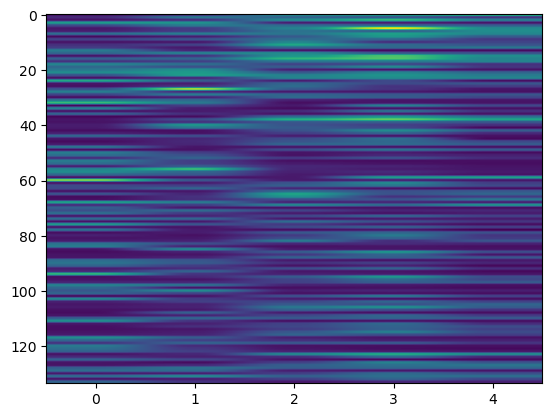

In [28]:
plt.imshow(SIMatrix[placeCells], aspect = 'auto')

In [38]:
dbs, pbs = trialize(deconvTraces, position, startIndices)
print(len(dbs))
dbs2, pbs2 = trialize(deconvTraces[:,1], position, startIndices)
print(np.shape(pbs2[50]))

120
(202,)


##### trials x nb neurons x trial length
##### trials x 1 x trial length

In [26]:
# SIMatrix = np.zeros((nNeurons, 5))
# baseMorphList = baseMorph[startIndices]

# for i in range(nNeurons):
#     dblocks, pblocks = trialize(deconvTraces[:,i], position, startIndices)
#     df, occp = positionalBinVec2(dblocks, pblocks)
#     SIMatrix[i,:] = GetSI(df, occp, baseMorphList)

In [29]:
SIMatrix = np.zeros((nNeurons, 5))
baseMorphList = baseMorph[startIndices]

dblocks, pblocks = trialize(deconvTraces, position, startIndices)
df, occp = positionalBinVec3(dblocks, pblocks)

(120, 45, 2050)


In [35]:
for i in range(nNeurons):
    SIMatrix[i,:] = GetSI(df[:,:,i], occp, baseMorphList)

In [36]:
threshold = np.percentile(SIMatrix, 98)
placeCells = np.unique(np.where(SIMatrix > threshold)[0])
print(len(placeCells), "place cells with a threshold of SI =", threshold )
print(placeCells)

134 place cells with a threshold of SI = 16.504736928643023
[   0    1    3    4    5    6    7    8   11   13   14   15   16   17
   20   22   23   25   27   30   31   32   41   43   45   46   47   51
   54   56   59   60   61   63   65   67   70   73   74   79   80   81
   88   97   98  100  101  103  107  108  124  128  129  135  143  146
  149  156  159  169  178  179  183  186  187  189  190  195  197  203
  205  210  212  213  221  223  226  228  232  237  242  243  245  249
  254  256  258  266  273  279  285  287  289  291  295  301  309  328
  335  339  357  359  363  365  375  393  394  433  438  439  442  451
  468  473  474  486  526  550  559  581  624  696  752  807  812  854
  857  860  924 1118 1123 1308 1331 1688]


## SI calculation for one ROI trace

In [13]:
dblocks, pblocks = trialize(deconvTraces[:,0], position, startIndices)
df, occp = positionalBinVec2(dblocks, pblocks)
# Setting up the aggregation of trials with the same base morph
baseMorphList = baseMorph[startIndices]; # Gives an array of size 120 (number of trials) with each element representing the
# base morph for the corresponding trial

base0 = np.where(baseMorphList == 0   )[0]
base1 = np.where(baseMorphList == 0.25)[0]
base2 = np.where(baseMorphList == 0.5 )[0]
base3 = np.where(baseMorphList == 0.75)[0]
base4 = np.where(baseMorphList == 1   )[0]

print(len(base0), "trials of base morph 0")
print(len(base1), "trials of base morph 0.25")
print(len(base2), "trials of base morph 0.5")
print(len(base3), "trials of base morph 0.75")
print(len(base4), "trials of base morph 1")

30 trials of base morph 0
20 trials of base morph 0.25
20 trials of base morph 0.5
20 trials of base morph 0.75
30 trials of base morph 1


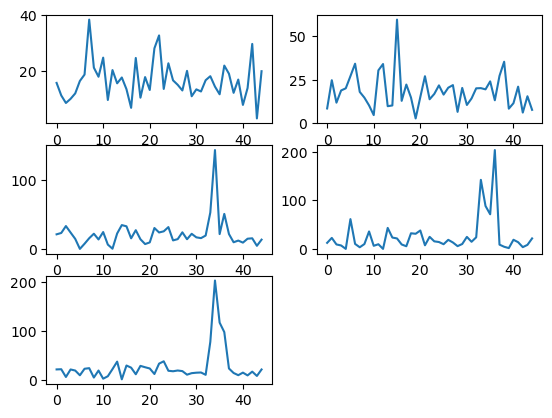

In [14]:
# Initializing the matrices for each base morph value, setting them up for aggregation

trialsBase0 = df[base0,:]
trialsBase1 = df[base1,:]
trialsBase2 = df[base2,:]
trialsBase3 = df[base3,:]
trialsBase4 = df[base4,:]

nBins = 45
aggBase = np.zeros([5, nBins])
# Averaging across all trials with the same baseMorph
aggBase[0,:] = np.sum(trialsBase0, axis = 0) / np.sum(occp[base0,:], axis = 0)
aggBase[1,:] = np.sum(trialsBase1, axis = 0) / np.sum(occp[base1,:], axis = 0)
aggBase[2,:] = np.sum(trialsBase2, axis = 0) / np.sum(occp[base2,:], axis = 0)
aggBase[3,:] = np.sum(trialsBase3, axis = 0) / np.sum(occp[base3,:], axis = 0)
aggBase[4,:] = np.sum(trialsBase4, axis = 0) / np.sum(occp[base4,:], axis = 0)

plt.figure(1)
plt.subplot(3,2,1)
plt.plot(aggBase[0,:])
plt.subplot(3,2,2)
plt.plot(aggBase[1,:])
plt.subplot(3,2,3)
plt.plot(aggBase[2,:])
plt.subplot(3,2,4)
plt.plot(aggBase[3,:])
plt.subplot(3,2,5)
plt.plot(aggBase[4,:])


In [16]:
# Aggregation of partial occupancies for each base morph value (summing up occupancy per bin,
# dividing by total time spent in that base value)
aggOccBase = np.zeros([5,nBins])

aggOccBase[0,:] = np.sum(occp[base0,:], axis = 0) / np.sum(occp[base0,:])
aggOccBase[1,:] = np.sum(occp[base1,:], axis = 0) / np.sum(occp[base1,:])
aggOccBase[2,:] = np.sum(occp[base2,:], axis = 0) / np.sum(occp[base2,:])
aggOccBase[3,:] = np.sum(occp[base3,:], axis = 0) / np.sum(occp[base3,:])
aggOccBase[4,:] = np.sum(occp[base4,:], axis = 0) / np.sum(occp[base4,:])


In [17]:
# For one cell, 5 base morphs
SI = np.zeros(5)

for i in range(5):
    # position-averaged activity rate of the cell across the trial
    lmbda = np.mean(aggBase[i,:])
    logTerm = np.log2((aggBase[i,:]+1e-5)/lmbda) # + 1 necessary due to using deconv data (log2(0) = -inf)
    SIPre = (aggOccBase[i,:] * aggBase[i,:] * logTerm)
    SI[i] = np.sum(SIPre)
    

In [18]:
print(SI)

[ 1.15652835  2.45219729 30.07901673 37.11033839 47.10186132]


<font size = '3'> We can see that this cell carries the most information for base morph values of 0.5, 0.75, 1, and very little for 0 and 0.25.<br> This is in agreement with what we see graphically above. </font>


### Divide cell into trials based on startIndices

this prepares the data for the positional binning, it takes the long neuronal data array and transforms it into two dimensions, rows corresponding to trials

In [7]:
def trialize(data, pos, startIndices):
    myIndices = np.append(startIndices, len(data))
    datablocks = [data[myIndices[i]:myIndices[i+1]] for i in range(len(myIndices)-1)]
    posblocks = [pos[myIndices[i]:myIndices[i+1]] for i in range(len(myIndices)-1)]
    np.array(datablocks,dtype=object)
    np.array(posblocks,dtype=object)
    
    return datablocks, posblocks


### Vectorized Binning Function

In [ ]:
# def positionalBinVec(data, pos):
#     bins = np.arange(0, 4.51, 0.1)
#     accResp = np.zeros_like(bins)
    
    
#     # Array of indices indicating which bin each timepoint belongs to, and count of how many elements per bin
#     binInds = np.digitize(pos,bins)
#     counterArr = np.histogram(pos,bins)[0]
    
#     # accumulate all values in bin
#     # datapoints falling outside the bins (reward region) are tacked onto the end of the resultant array
#     np.add.at(accResp, binInds-1, data)
    
    
#     return accResp[:-1], counterArr

In [ ]:
# # Number of positional bins
# mynBins = 45

# # Creating the dataframe with trials x bins
# mydf = np.zeros([nTrials, mynBins])
# myoccp = np.zeros([nTrials, mynBins])

# # Which cell are we performing the binning on?
# cellTrace = deconvTraces[:,0]

# # Make sure to add data for last trial DONE
# for i in range(nTrials):
#     if i < nTrials - 1:
#         l = int(startIndices[i])
#         r = int(startIndices[i+1])
#         mydf[i,:], myoccp[i,:] = positionalBinVec(cellTrace[l:r], position[l:r])
#     else:
#         l = int(startIndices[i])
#         mydf[i,:], myoccp[i,:] = positionalBinVec(cellTrace[l:], position[l:])

### Alternative positional binning function

The binning function was previously designed in a way to handle each trial on its own. It is fed the trials via a for loop that goes through the data matrix using the startIndices as limits to chop it up for each run of the positionalBin function.

The below code takes the 'trialized' data as input, and runs a for loop inside to accumulate the data from each trial. The output is then a <b>nTrials x nBins</b> matrix each for the accumulated response and the occupancy matrices.

##### Note:
There remains a for loop in this function, one that iterates over the trials. At the moment I do not see a way to overcome this, I need to figure out how to use digitize, histogram, and np.add.at in 2D.

In [ ]:
# def positionalBinVec2(datablocks, posblocks): # This positional binning function takes in the output from trialize
#     nTrials = len(datablocks)
#     bins = np.arange(0, 4.51, 0.1)
#     accResp = np.zeros((nTrials,len(bins)))
#     counterMat = np.zeros((nTrials,len(bins)-1))
    
#     for i in range(nTrials):
#         # Array of indices indicating which bin each timepoint belongs to, and count of how many elements per bin
#         binInds = np.digitize(posblocks[i],bins) - 1
#         counterMat[i,:] = np.histogram(posblocks[i],bins)[0]
#         tempAcc = np.zeros_like(len(bins)-1)
        
#         # accumulate all values in bin
#         np.add.at(accResp[i,:], binInds, datablocks[i])
        
    
#     return accResp[:,:-1], counterMat

In [ ]:
# # Number of positional bins
# mynBins = 45

# dbs, pbs = trialize(cellTrace, position, startIndices)

# mydf2, myoccp2 = positionalBinVec2(dbs, pbs)

In [ ]:
# a = mydf2[:,:]/myoccp2[:,:]
# b = mydf[:,:]/myoccp[:,:]
# np.isclose(a,b).all()

# #i = 5
# #print(mydf2[i,:]/myoccp2[i,:]) # From positionalBinVec2
# #print(mydf[i,:]/myoccp[i,:])   # From positionalBinVec
# #print(df[i,:])                 # From positionalBin 

# Testing area

In [ ]:
mybinedges = [0,5,10,15]
mypos = np.array([[0,1,1,2,4,5,6,7,7,9,-5,10,12,13],[0,1,1,3,5,6,6,7,8,9,-1,9,9,9]])
mybininds = np.digitize(mypos,mybinedges)
mycounter = np.histogram(mypos, mybinedges)[0]
mydata = np.array([[1,1,1,0,0,0,0,0,1,1,0,1,1,1], [1,1,1,0,0,0,0,0,1,1,0,1,1,1]])
          

binned_data = np.zeros((2,4), int)
# np.add.at(binned_data, mybininds-1, mydata)
idx = np.arange(len(mybininds))
#np.add.at(binned_data, (np.arange(mydata.shape[0]), mybininds), mydata)

print(mybininds)
print(mycounter)
print(np.shape(mydata))

a = np.tile(np.arange(mydata.shape[0]).reshape(2,1), 14)
# print(binned_data[(a, mybininds-1)])
np.add.at(binned_data, (a,mybininds-1), mydata)
print(binned_data)

# The issue is that each data row has a different number of elements. I cannot create the 'a' matrix properly... for now

In [8]:
def positionalBinVec3(datablocks, posblocks): # This positional binning function takes in the output from trialize
    nTrials = len(datablocks) # This is still okay
    bins = np.arange(0, 4.51, 0.1)
    accResp = np.zeros((nTrials,len(bins),nNeurons)) # New dimension added, nNeurons
    counterMat = np.zeros((nTrials,len(bins)-1))
    
    for i in range(nTrials):
        # Array of indices indicating which bin each timepoint belongs to, and count of how many elements per bin
        binInds = np.digitize(posblocks[i],bins) - 1
        counterMat[i,:] = np.histogram(posblocks[i],bins)[0]
#         tempAcc = np.zeros_like(len(bins)-1)
        
        # accumulate all values in bin
        np.add.at(accResp[i,:,:], binInds, datablocks[i][:])
        
    
    return accResp[:,:-1,:], counterMat

In [14]:
SIMatrix = np.zeros((nNeurons, 5))
baseMorphList = baseMorph[startIndices]

dblocks, pblocks = trialize(deconvTraces, position, startIndices)
df, occp = positionalBinVec3(dblocks, pblocks)


In [16]:
for i in range(nNeurons):
    SIMatrix[i,:] = GetSI(df[:,:,i], occp, baseMorphList)

#### Identify which ROIs are place cells for each given baseMorph

In [17]:
threshold = np.percentile(SIMatrix, 97)
# placeCells = np.unique(np.where(SIMatrix > threshold)[0])
placeCells_morph0 = np.where(SIMatrix[:,0] > threshold)[0]
placeCells_morph1 = np.where(SIMatrix[:,1] > threshold)[0]
placeCells_morph2 = np.where(SIMatrix[:,2] > threshold)[0]
placeCells_morph3 = np.where(SIMatrix[:,3] > threshold)[0]
placeCells_morph4 = np.where(SIMatrix[:,4] > threshold)[0]


print(len(placeCells_morph0), "place cells for base morph = 0, with a threshold of SI =", threshold )
print(placeCells_morph0)


65 place cells for base morph = 0, with a threshold of SI = 14.330555940761043
[   4    8    9   17   19   20   23   27   30   31   32   45   54   60
   61   65   70   86   87   98  107  124  128  135  143  149  156  159
  178  189  197  205  212  221  226  232  249  254  279  285  287  295
  335  339  357  359  365  410  442  451  492  510  513  550  559  571
  624  631  696  752  854  924 1118 1308 1688]


#### Get the average activity of chosen cells in trials at each respective morph

In [34]:
# Needed: average activity of placeCells_morph0 in "base0" trials

# df containing activity of morph0 place cells
df_0 = df[:,:,placeCells_morph0]
df_1 = df[:,:,placeCells_morph1] 
df_2 = df[:,:,placeCells_morph2]
df_3 = df[:,:,placeCells_morph3]
df_4 = df[:,:,placeCells_morph4]

# base morph for the corresponding trial

base0 = np.where(baseMorphList == 0   )[0]
base1 = np.where(baseMorphList == 0.25)[0]
base2 = np.where(baseMorphList == 0.5 )[0]
base3 = np.where(baseMorphList == 0.75)[0]
base4 = np.where(baseMorphList == 1   )[0]

  
# Averaging across all trials with the same baseMorph
avgAct0_placeCells0 = np.sum(df_0[base0,:,:], axis = 0) / np.sum(occp[base0,:], axis = 0).reshape(45,1)
avgAct1_placeCells0 = np.sum(df_0[base1,:,:], axis = 0) / np.sum(occp[base1,:], axis = 0).reshape(45,1)
avgAct2_placeCells0 = np.sum(df_0[base2,:,:], axis = 0) / np.sum(occp[base2,:], axis = 0).reshape(45,1)
avgAct3_placeCells0 = np.sum(df_0[base3,:,:], axis = 0) / np.sum(occp[base3,:], axis = 0).reshape(45,1)
avgAct4_placeCells0 = np.sum(df_0[base4,:,:], axis = 0) / np.sum(occp[base4,:], axis = 0).reshape(45,1)

# Averaging across all trials with the same baseMorph
avgAct0_placeCells1 = np.sum(df_1[base0,:,:], axis = 0) / np.sum(occp[base0,:], axis = 0).reshape(45,1)
avgAct1_placeCells1 = np.sum(df_1[base1,:,:], axis = 0) / np.sum(occp[base1,:], axis = 0).reshape(45,1)
avgAct2_placeCells1 = np.sum(df_1[base2,:,:], axis = 0) / np.sum(occp[base2,:], axis = 0).reshape(45,1)
avgAct3_placeCells1 = np.sum(df_1[base3,:,:], axis = 0) / np.sum(occp[base3,:], axis = 0).reshape(45,1)
avgAct4_placeCells1 = np.sum(df_1[base4,:,:], axis = 0) / np.sum(occp[base4,:], axis = 0).reshape(45,1)

# Averaging across all trials with the same baseMorph
avgAct0_placeCells2 = np.sum(df_2[base0,:,:], axis = 0) / np.sum(occp[base0,:], axis = 0).reshape(45,1)
avgAct1_placeCells2 = np.sum(df_2[base1,:,:], axis = 0) / np.sum(occp[base1,:], axis = 0).reshape(45,1)
avgAct2_placeCells2 = np.sum(df_2[base2,:,:], axis = 0) / np.sum(occp[base2,:], axis = 0).reshape(45,1)
avgAct3_placeCells2 = np.sum(df_2[base3,:,:], axis = 0) / np.sum(occp[base3,:], axis = 0).reshape(45,1)
avgAct4_placeCells2 = np.sum(df_2[base4,:,:], axis = 0) / np.sum(occp[base4,:], axis = 0).reshape(45,1)

# Averaging across all trials with the same baseMorph
avgAct0_placeCells3 = np.sum(df_3[base0,:,:], axis = 0) / np.sum(occp[base0,:], axis = 0).reshape(45,1)
avgAct1_placeCells3 = np.sum(df_3[base1,:,:], axis = 0) / np.sum(occp[base1,:], axis = 0).reshape(45,1)
avgAct2_placeCells3 = np.sum(df_3[base2,:,:], axis = 0) / np.sum(occp[base2,:], axis = 0).reshape(45,1)
avgAct3_placeCells3 = np.sum(df_3[base3,:,:], axis = 0) / np.sum(occp[base3,:], axis = 0).reshape(45,1)
avgAct4_placeCells3 = np.sum(df_3[base4,:,:], axis = 0) / np.sum(occp[base4,:], axis = 0).reshape(45,1)

# Averaging across all trials with the same baseMorph
avgAct0_placeCells4 = np.sum(df_4[base0,:,:], axis = 0) / np.sum(occp[base0,:], axis = 0).reshape(45,1)
avgAct1_placeCells4 = np.sum(df_4[base1,:,:], axis = 0) / np.sum(occp[base1,:], axis = 0).reshape(45,1)
avgAct2_placeCells4 = np.sum(df_4[base2,:,:], axis = 0) / np.sum(occp[base2,:], axis = 0).reshape(45,1)
avgAct3_placeCells4 = np.sum(df_4[base3,:,:], axis = 0) / np.sum(occp[base3,:], axis = 0).reshape(45,1)
avgAct4_placeCells4 = np.sum(df_4[base4,:,:], axis = 0) / np.sum(occp[base4,:], axis = 0).reshape(45,1)




### Testing for rose-gold plot

In [25]:
testarray = np.array([ 3, 2, 2, 2])
idxarray = [1,2,3,0]
print(np.argsort(testarray))

[1 2 3 0]


C:\Users\tarek\AppData\Local\Temp\ipykernel_22024\2643713151.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  A = filters.gaussian_filter(A,sig)
C:\Users\tarek\AppData\Local\Temp\ipykernel_22024\2643713151.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  One = filters.gaussian_filter(One,sig)


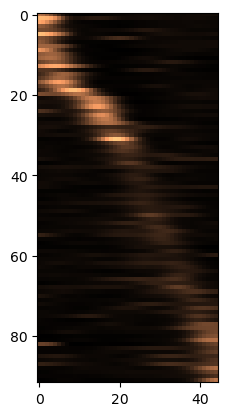

In [38]:
cellsToPlot = np.transpose(avgAct3_placeCells3[:,np.argsort(np.argmax(avgAct3_placeCells3,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')

C:\Users\tarek\AppData\Local\Temp\ipykernel_22024\2643713151.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  A = filters.gaussian_filter(A,sig)
C:\Users\tarek\AppData\Local\Temp\ipykernel_22024\2643713151.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  One = filters.gaussian_filter(One,sig)


([], [])

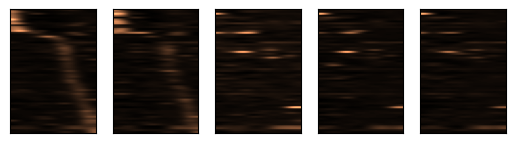

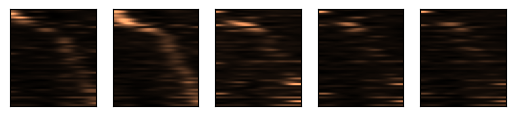

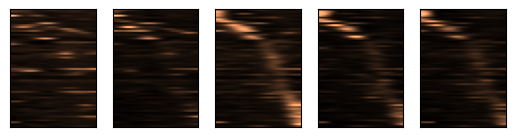

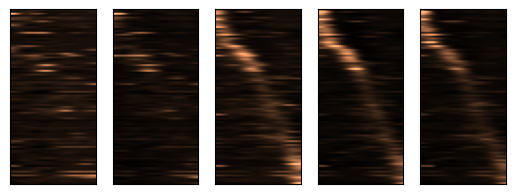

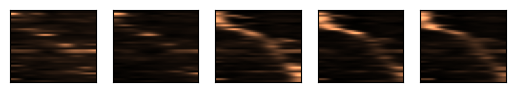

In [47]:
# first row
plt.figure()
plt.subplot(1,5,1)
cellsToPlot = np.transpose(avgAct0_placeCells0[:,np.argsort(np.argmax(avgAct0_placeCells0,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,2)
cellsToPlot = np.transpose(avgAct1_placeCells0[:,np.argsort(np.argmax(avgAct0_placeCells0,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,3)
cellsToPlot = np.transpose(avgAct2_placeCells0[:,np.argsort(np.argmax(avgAct0_placeCells0,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,4)
cellsToPlot = np.transpose(avgAct3_placeCells0[:,np.argsort(np.argmax(avgAct0_placeCells0,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,5)
cellsToPlot = np.transpose(avgAct4_placeCells0[:,np.argsort(np.argmax(avgAct0_placeCells0,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

# 2nd row
plt.figure()
plt.subplot(1,5,1)
cellsToPlot = np.transpose(avgAct0_placeCells1[:,np.argsort(np.argmax(avgAct1_placeCells1,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,2)
cellsToPlot = np.transpose(avgAct1_placeCells1[:,np.argsort(np.argmax(avgAct1_placeCells1,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,3)
cellsToPlot = np.transpose(avgAct2_placeCells1[:,np.argsort(np.argmax(avgAct1_placeCells1,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,4)
cellsToPlot = np.transpose(avgAct3_placeCells1[:,np.argsort(np.argmax(avgAct1_placeCells1,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,5)
cellsToPlot = np.transpose(avgAct4_placeCells1[:,np.argsort(np.argmax(avgAct1_placeCells1,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

# 3rd row
plt.figure()
plt.subplot(1,5,1)
cellsToPlot = np.transpose(avgAct0_placeCells2[:,np.argsort(np.argmax(avgAct2_placeCells2,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,2)
cellsToPlot = np.transpose(avgAct1_placeCells2[:,np.argsort(np.argmax(avgAct2_placeCells2,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,3)
cellsToPlot = np.transpose(avgAct2_placeCells2[:,np.argsort(np.argmax(avgAct2_placeCells2,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,4)
cellsToPlot = np.transpose(avgAct3_placeCells2[:,np.argsort(np.argmax(avgAct2_placeCells2,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,5)
cellsToPlot = np.transpose(avgAct4_placeCells2[:,np.argsort(np.argmax(avgAct2_placeCells2,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

# 4th row
plt.figure()
plt.subplot(1,5,1)
cellsToPlot = np.transpose(avgAct0_placeCells3[:,np.argsort(np.argmax(avgAct3_placeCells3,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,2)
cellsToPlot = np.transpose(avgAct1_placeCells3[:,np.argsort(np.argmax(avgAct3_placeCells3,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,3)
cellsToPlot = np.transpose(avgAct2_placeCells3[:,np.argsort(np.argmax(avgAct3_placeCells3,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,4)
cellsToPlot = np.transpose(avgAct3_placeCells3[:,np.argsort(np.argmax(avgAct3_placeCells3,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,5)
cellsToPlot = np.transpose(avgAct4_placeCells3[:,np.argsort(np.argmax(avgAct3_placeCells3,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

# 5th row
plt.figure()
plt.subplot(1,5,1)
cellsToPlot = np.transpose(avgAct0_placeCells4[:,np.argsort(np.argmax(avgAct4_placeCells4,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,2)
cellsToPlot = np.transpose(avgAct1_placeCells4[:,np.argsort(np.argmax(avgAct4_placeCells4,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,3)
cellsToPlot = np.transpose(avgAct2_placeCells4[:,np.argsort(np.argmax(avgAct4_placeCells4,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,4)
cellsToPlot = np.transpose(avgAct3_placeCells4[:,np.argsort(np.argmax(avgAct4_placeCells4,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

plt.subplot(1,5,5)
cellsToPlot = np.transpose(avgAct4_placeCells4[:,np.argsort(np.argmax(avgAct4_placeCells4,axis=0))])
plt.imshow(figsmooth(cellsToPlot,[0,3]),cmap='copper')
plt.xticks([])
plt.yticks([])

In [36]:
from scipy.ndimage import filters
def figsmooth(A,sig):
    '''apply Gaussian smoothing to matrix A containing nans with kernel sig
    without propogating nans'''

    # find zero indices to weight the smoothing matrix
    zero_inds = np.where(A == 0)

    # inversely weight zero indices
    One = np.ones(A.shape)
    One[zero_inds] = .001
    A = filters.gaussian_filter(A,sig)
    One = filters.gaussian_filter(One,sig)
    return A/One

In [ ]:
figsmooth(df,[0,3])